## LSTM Auto-Encoder-Decoder for Anomaly Detection: 

## Detect anomalous points on time series data of cpu utilization

In [1]:
import numpy as np
import pandas as pd

from keras.layers import RepeatVector
from keras.layers.core import Dropout, Dense, Activation
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(23)

### Read Data for Cpu utilization, we want to reconstruct the time series using LSTM based Auto-Encoder

In [3]:
df = pd.read_csv('df_merged.csv', parse_dates=['days'], index_col='days')

In [4]:
df.sample(5)

,dt,cur_time_in_gmt,cpu_utilization_pctg,hour,cpu_utilization_pctg_extrapolated,is_extrapolated
days,,,,,,
2017-07-21 01:00:00,7/20/2017,7/21/2017 1:00,50.833,1,50.833,False
2017-04-06 21:00:00,4/6/2017,4/6/2017 21:00,48.611,21,48.611,False
2017-05-12 21:00:00,5/12/2017,5/12/2017 21:00,58.889,21,58.889,False
2017-04-17 07:00:00,4/17/2017,4/17/2017 7:00,26.382,7,26.382,False
2017-04-04 07:00:00,4/4/2017,4/4/2017 7:00,34.167,7,34.167,False


**We collect cpu usage data per hour eveyday, so there are 24 readings per day**

In [5]:
df = df[['cpu_utilization_pctg_extrapolated']]
df.columns = ['cpu_util_pctg']
df.sample(5)

,cpu_util_pctg
days,
2017-04-15 03:00:00,61.066
2017-06-10 20:00:00,46.125
2017-07-06 03:00:00,55.833
2017-05-26 08:00:00,31.389
2017-05-02 23:00:00,33.629


In [6]:
#from sklearn.preprocessing import StandardScaler

# Normalize the  data (center around 0 and scale to remove the variance).
#scaler = StandardScaler()
#df['cpu_util_pctg'] = scaler.fit_transform(df['cpu_util_pctg'].values.reshape(-1, 1))

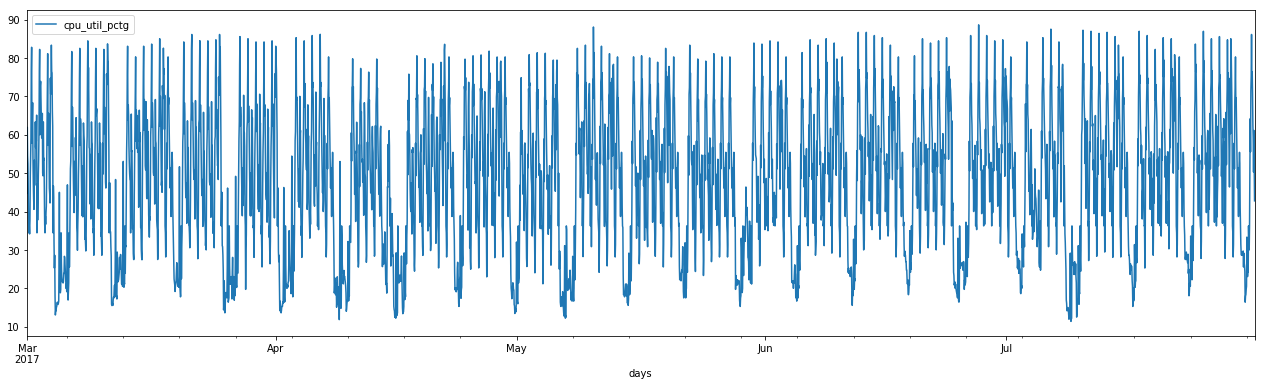

In [7]:
df.plot(figsize=(22,6));

In [8]:
len(df)

3672

In [9]:
df['cpu_util_pctg'] = df['cpu_util_pctg'] / 100

### Create the training, validation and test sets

In [10]:
signal_train = df['2017-03-01':'2017-05-31'].values # March to May
signal_valid = df['2017-06-01':'2017-06-30'].values # June
signal_test = df['2017-07-01':'2017-07-31'].values # July

**Prepare Training Sequences: Create windows of 48 data points each**

In [11]:
window_length = 12 # Why 48? 24 readings in a day, so took for 2 days

In [12]:
train_windows = []

In [13]:
for window_start in range(0, len(signal_train) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(signal_train[window_range])
    train_windows.append(window)

In [14]:
len(train_windows)

2197

In [15]:
len(signal_test)

744

In [16]:
#x_train = np.expand_dims(np.array(train_windows), axis=2)
#x_train.shape

In [17]:
x_train = np.array(train_windows)
x_train.shape

(2197, 12, 1)

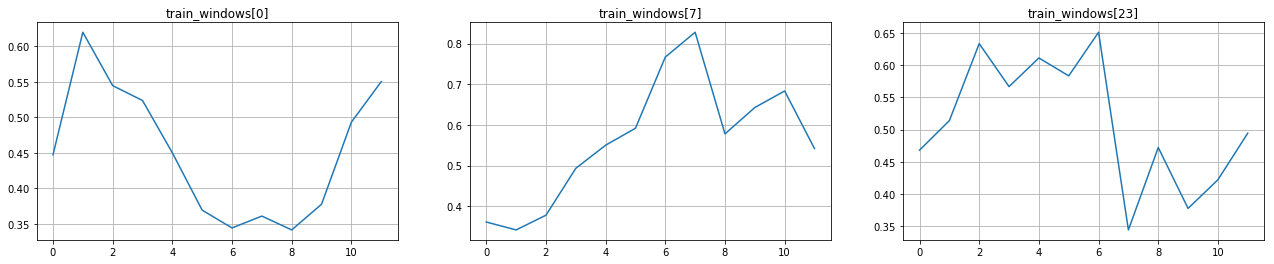

In [18]:
# Visualize the training sequences
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(train_windows[0])
plt.title('train_windows[0]')
plt.grid(True)
plt.subplot(132)
plt.plot(train_windows[7])
plt.title('train_windows[7]')
plt.grid(True)
plt.subplot(133)
plt.plot(train_windows[23])
plt.title('train_windows[23]')
plt.grid(True)
plt.show();

**Prepare Validation Sequences: Create windows of 48 data points each**

In [19]:
valid_windows = []

In [20]:
for window_start in range(0, len(signal_valid) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(signal_valid[window_range])
    valid_windows.append(window)

In [21]:
#x_valid = np.expand_dims(np.array(valid_windows), axis=2)
#x_valid.shape

In [22]:
x_valid = np.array(valid_windows)
x_valid.shape

(709, 12, 1)

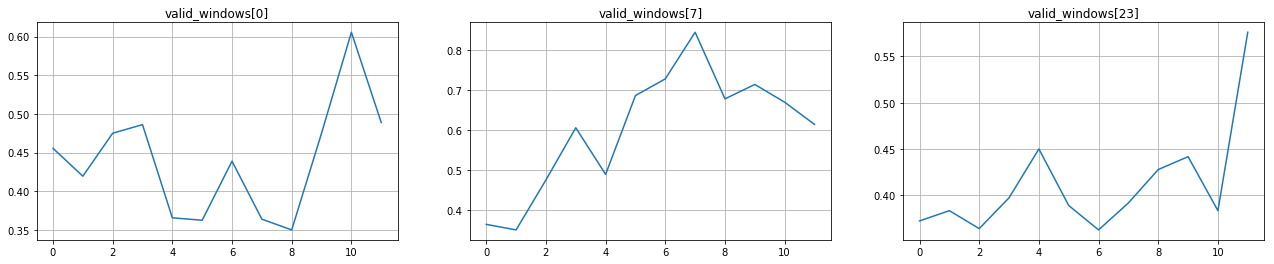

In [23]:
# Visualize the validation sequences
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(valid_windows[0])
plt.title('valid_windows[0]')
plt.grid(True)
plt.subplot(132)
plt.plot(valid_windows[7])
plt.title('valid_windows[7]')
plt.grid(True)
plt.subplot(133)
plt.plot(valid_windows[23])
plt.title('valid_windows[23]')
plt.grid(True)
plt.show();

### Create the LSTM Auto-Encoder Model

In [24]:
input_length = window_length
input_dim = 1
hidden_dim = 12
batch_size = 48 # batch of 7 days of data, 24 readings/day x 7 days
epochs = 50

In [25]:
def mode11():
    m = Sequential()
    m.add(LSTM(units=2 * hidden_dim, input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(LSTM(units=hidden_dim, return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=hidden_dim, return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=2 * hidden_dim, return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(Dense(1, activation='linear'))
    return m

In [26]:
def model2():
    m = Sequential()
    m.add(LSTM(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(LSTM(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=2 * hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(Dense(1, activation='sigmoid'))
    m.add(Activation('linear'))
    return m

In [27]:
#m = model1()
m = model2()

In [28]:
m.compile(loss='mse', optimizer='adam')

In [29]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 24)            2496      
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 24)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 12)            1776      
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 12, 12)            1200      
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 24)            3552      
__________

In [30]:
history = m.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, x_valid)).history

Train on 2197 samples, validate on 709 samples
Epoch 1/50
2197/2197 [==============================] - 7s - loss: 0.0349 - val_loss: 0.0310
Epoch 2/50
2197/2197 [==============================] - 4s - loss: 0.0335 - val_loss: 0.0283
Epoch 3/50
2197/2197 [==============================] - 4s - loss: 0.0294 - val_loss: 0.0250
Epoch 4/50
2197/2197 [==============================] - 4s - loss: 0.0270 - val_loss: 0.0227
Epoch 5/50
2197/2197 [==============================] - 4s - loss: 0.0239 - val_loss: 0.0191
Epoch 6/50
2197/2197 [==============================] - 4s - loss: 0.0204 - val_loss: 0.0156
Epoch 7/50
2197/2197 [==============================] - 4s - loss: 0.0173 - val_loss: 0.0119
Epoch 8/50
2197/2197 [==============================] - 4s - loss: 0.0146 - val_loss: 0.0116
Epoch 9/50
2197/2197 [==============================] - 4s - loss: 0.0126 - val_loss: 0.0085
Epoch 10/50
2197/2197 [==============================] - 4s - loss: 0.0113 - val_loss: 0.0068
Epoch 11/50
2197/2197 

In [31]:
#model_file = 'auto-encoder-anom.h5'
#m.save(model_file)

In [32]:
pred_x_valid = m.predict(x_valid)

### Visualize the reconstruction on the validation set (select random sets)

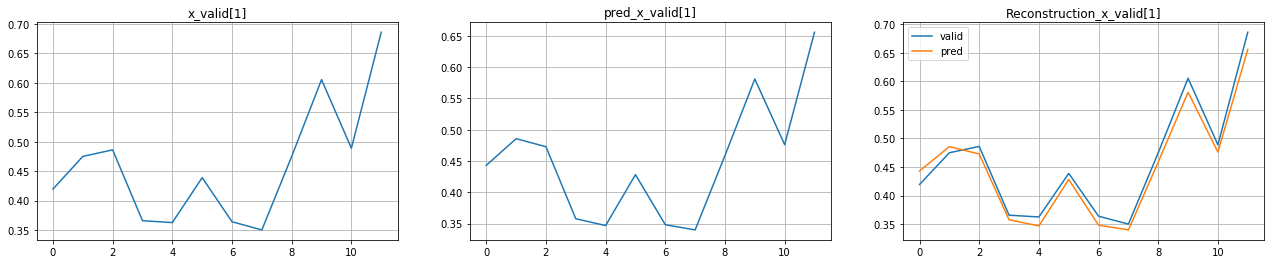

In [33]:
# Visualize the reconstruction on validation sequence[1]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_valid[1])
plt.title('x_valid[1]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_valid[1])
plt.title('pred_x_valid[1]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_valid[1], label='valid')
plt.plot(pred_x_valid[1], label='pred')
plt.legend(loc='best')
plt.title('Reconstruction_x_valid[1]')
plt.grid(True)
plt.show();

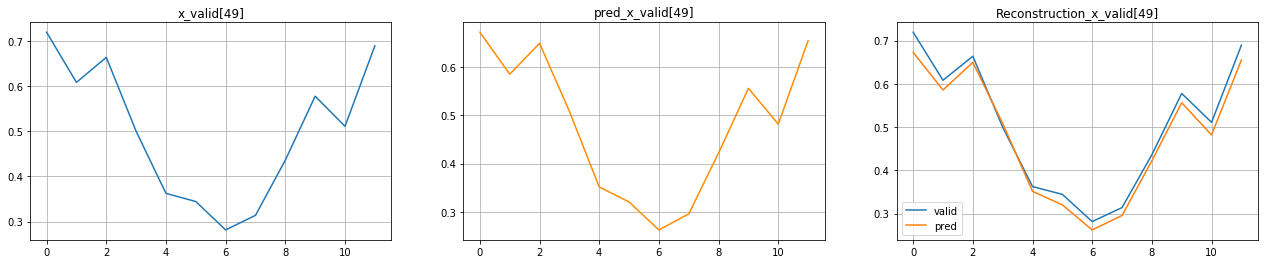

In [34]:
# Visualize the reconstruction on validation sequence[49]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_valid[49])
plt.title('x_valid[49]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_valid[49], color='darkorange')
plt.title('pred_x_valid[49]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_valid[49], label='valid')
plt.plot(pred_x_valid[49], label='pred')
plt.legend(loc='best')
plt.title('Reconstruction_x_valid[49]')
plt.grid(True)
plt.show();

### Summarise Model Loss Over Training Epochs

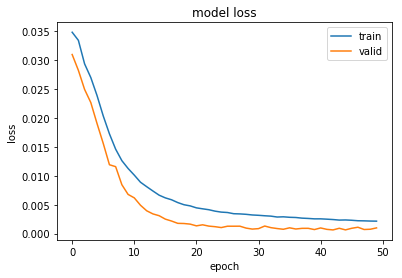

In [35]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.show()

In [36]:
signal_test[201]

array([ 0.26667])

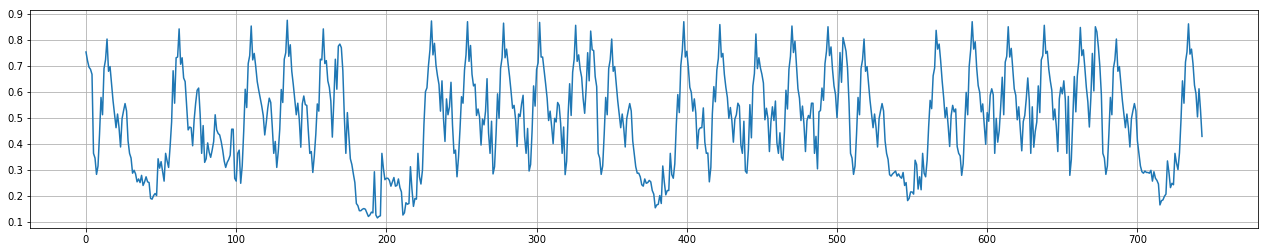

In [37]:
plt.figure(figsize=(22, 4))
plt.plot(signal_test)
plt.grid(True)

### Simulate Anomalies on the test set (select random points)

In [38]:
simulated_signal_test = np.copy(signal_test)

In [39]:
random_indices = [201, 422] # random points chosen
simulated_signal_test[random_indices]

array([[ 0.26667],
       [ 0.85833]])

In [40]:
simulated_signal_test[201] = 0.81
simulated_signal_test[422] = 0.35

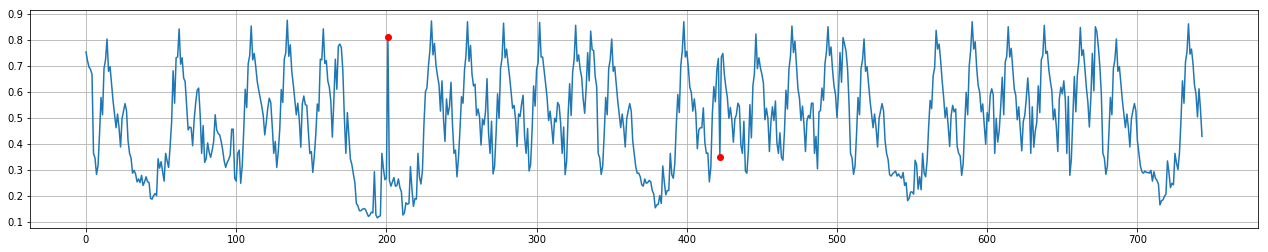

In [41]:
plt.figure(figsize=(22, 4))
plt.plot(simulated_signal_test)
plt.plot(201, simulated_signal_test[201], marker='o', color='red')
plt.plot(422, simulated_signal_test[422], marker='o', color='red')
plt.grid(True)

**Prepare Test Sequences: Create windows of 48 data points each**

In [42]:
test_windows = []
contain_outliers= []

In [43]:
for window_start in range(0, len(simulated_signal_test) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(simulated_signal_test[window_range])
    is_outlier = len(set(window_range).intersection(set(random_indices))) > 0
    contain_outliers.append(is_outlier)
    test_windows.append(window)

In [44]:
x_test = np.array(test_windows)
x_test.shape

(733, 12, 1)

In [45]:
pred_x_test = m.predict(x_test)

### Visualize the reconstruction on the simulated test set (select random sets)

In [46]:
outlier_indices = np.where(contain_outliers)[0]

In [47]:
outlier_indices

array([190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422])

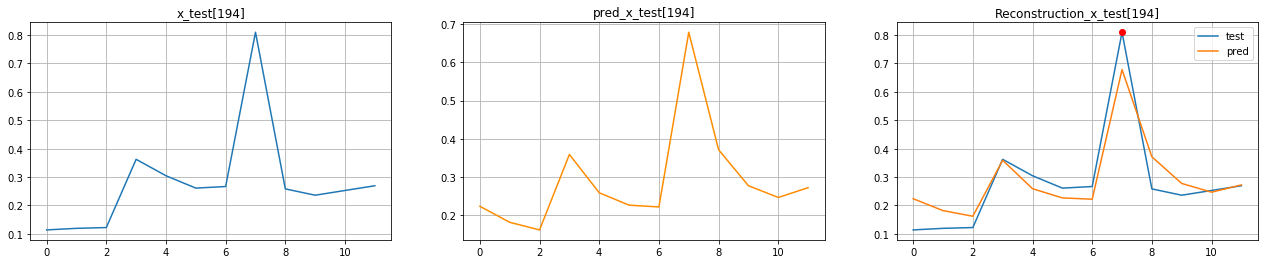

In [48]:
# Visualize the reconstruction on a random test sequence
left = random_indices[0]
choose = outlier_indices[4]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_test[choose])
plt.title('x_test[{0}]'.format(choose))
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_test[choose], color='darkorange')
plt.title('pred_x_test[{0}]'.format(choose))
plt.grid(True)
plt.subplot(133)
plt.plot(x_test[choose], label='test')
plt.plot(pred_x_test[choose], label='pred')
plt.plot(left - choose, x_test[choose][left-choose], marker='o', color='red')
plt.legend(loc='best')
plt.title('Reconstruction_x_test[{0}]'.format(choose))
plt.grid(True)
plt.show();

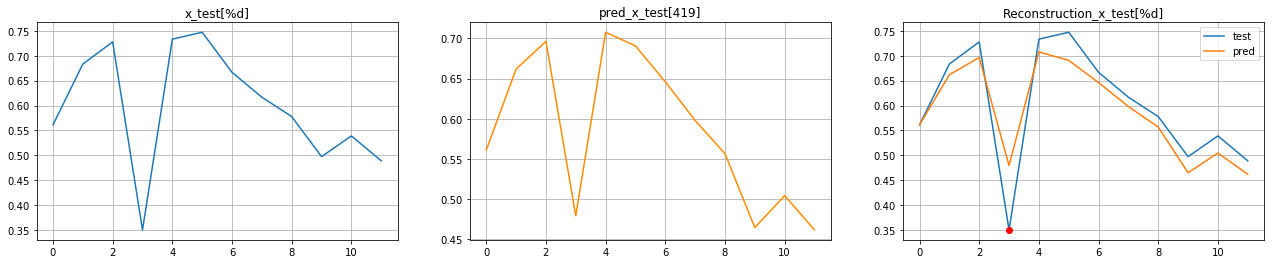

In [49]:
# Visualize the reconstruction on a random test sequence
left = random_indices[1]
choose = outlier_indices[-4]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_test[choose])
plt.title('x_test[{0}]'.format(choose))
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_test[choose], color='darkorange')
plt.title('pred_x_test[{0}]'.format(choose))
plt.grid(True)
plt.subplot(133)
plt.plot(x_test[choose], label='test')
plt.plot(pred_x_test[choose], label='pred')
plt.plot(left - choose, x_test[choose][left-choose], marker='o', color='red')
plt.legend(loc='best')
plt.title('Reconstruction_x_test[{0}]'.format(choose))
plt.grid(True)
plt.show();

In [50]:
mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test - x_test), axis=1))
mae_of_predictions

array([ 0.0106255 ,  0.01140088,  0.0093328 ,  0.00795606,  0.00535415,
        0.0012449 ,  0.00127849,  0.00122892,  0.00136702,  0.00148871,
        0.00107063,  0.00166268,  0.00124356,  0.00485731,  0.00671645,
        0.00115605,  0.00144531,  0.00083052,  0.00084646,  0.00089729,
        0.00143346,  0.00078449,  0.0014358 ,  0.00135729,  0.00138746,
        0.00140846,  0.00140977,  0.00141588,  0.00139321,  0.00135733,
        0.00133001,  0.00135568,  0.00135136,  0.00133495,  0.00144059,
        0.00138372,  0.00160495,  0.00133496,  0.00287333,  0.00282895,
        0.00279281,  0.00275306,  0.00248314,  0.00217513,  0.00193526,
        0.0016359 ,  0.00104058,  0.00182631,  0.00187352,  0.00192162,
        0.00199584,  0.00356323,  0.00358929,  0.00364747,  0.00366148,
        0.00369018,  0.0038348 ,  0.00397889,  0.00352336,  0.00354703,
        0.00258348,  0.00849343,  0.01036693,  0.00170809,  0.00258348,
        0.00132601,  0.00068367,  0.00066758,  0.0015661 ,  0.00

In [51]:
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
mae_threshold

0.0076548363163974984

In [52]:
pred_outlier_indices = np.where(mae_of_predictions > mae_threshold)[0]
pred_outlier_indices

array([  0,   1,   2,   3,  61,  62, 109, 110, 133, 134, 157, 158, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
       201, 211, 212, 229, 230, 253, 254, 277, 278, 301, 302, 325, 326,
       327, 335, 336, 397, 398, 411, 412, 413, 414, 415, 416, 417, 418,
       419, 420, 446, 469, 470, 493, 494, 565, 566, 589, 590, 613, 614,
       637, 638, 644, 645, 646, 647, 648, 649, 651, 652, 654, 661, 662,
       663, 664, 665, 666, 667, 668, 669, 671, 672, 673])

In [53]:
len(pred_outlier_indices)

88

In [54]:
outlier_indices

array([190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422])

In [55]:
len(outlier_indices)

24

In [56]:
set(outlier_indices).intersection(set(pred_outlier_indices))

{190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420}

**Metrics**

In [57]:
tp = len(set(outlier_indices).intersection(set(pred_outlier_indices)))

In [58]:
fn = len(set(outlier_indices) - set(pred_outlier_indices))

In [59]:
fp = len(set(pred_outlier_indices) - set(outlier_indices))

In [60]:
all_indices = set(range(len(x_test))) 
tn = len((all_indices - set(outlier_indices)).intersection(all_indices - set(pred_outlier_indices)))

In [61]:
precision = float(tp) / (tp + fp)

In [62]:
hit_rate = float(tp) / (tp + fn)

In [63]:
accuracy = float(tp + tn) / (tp + tn + fp + fn)

In [64]:
print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))

precision = 0.25, hit_rate = 0.9166666666666666, accuracy = 0.9072305593451568
